<a href="https://colab.research.google.com/github/Richard-Kyuhyong/APU/blob/main/MVP_MDP_ERC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Portfolio Optimization in Python : Trial and error method
https://www.codingfinance.com/post/2018-05-31-portfolio-opt-in-python/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web

In [ ]:
#tick = ['now', 'team', 'okta', 'net', 'apps','fvrr','vldr','u','rmg','qcln']
#tick = ['fsly', 'sq', 'twlo', 'aapl', 'crwd','tsla','crm','se','soxx','arkk','nio','snap','xpev','fngu','amzn','pltr','sqqq']
#tick=['AAPL','amd','amzn',  'googl','intu','msft','nvda','qcom','tsla','wkhs','nflx', 'sbe','nio','fngu','pacb','dkng']
#tick=['baba', 'qqq', 'tqqq','idrv','crsp','iova', 'lgvw','li','mcrb','mtls','nvta','pins','psnl','sq','niu']
tick =['crwd','ddog','docu','fsly','ttd','twlo','zm','zs','clou']
price_data = web.get_data_yahoo(tick,
                           start = '2019-01-01',
                           end = '2021-02-26')['Adj Close']

In [ ]:
log_ret = np.log(price_data/price_data.shift(1))

In [ ]:
cov_mat = log_ret.cov() * 252
#cov_mat

In [ ]:
# Simulating 5000 portfolios
num_port = 5000
# Creating an empty array to store portfolio weights
all_wts = np.zeros((num_port, len(price_data.columns)))
# Creating an empty array to store portfolio returns
port_returns = np.zeros((num_port))
# Creating an empty array to store portfolio risks
port_risk = np.zeros((num_port))
# Creating an empty array to store portfolio sharpe ratio
sharpe_ratio = np.zeros((num_port))

In [ ]:
for i in range(num_port):
  wts = np.random.uniform(size = len(price_data.columns))
  wts = wts/np.sum(wts)
  
  # saving weights in the array
  
  all_wts[i,:] = wts
  
  # Portfolio Returns
  
  port_ret = np.sum(log_ret.mean() * wts)
  port_ret = (port_ret + 1) ** 252 - 1
  
  # Saving Portfolio returns
  
  port_returns[i] = port_ret
  
  
  # Portfolio Risk
  
  port_sd = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts)))
  
  port_risk[i] = port_sd
  
  # Portfolio Sharpe Ratio
  # Assuming 0% Risk Free Rate
  
  sr = port_ret / port_sd
  sharpe_ratio[i] = sr

#Minimum Variance

In [ ]:
names = price_data.columns
min_var = all_wts[port_risk.argmin()]
print(tick)
print(min_var)

['crwd', 'ddog', 'docu', 'fsly', 'ttd', 'twlo', 'zm', 'zs', 'clou']
[0.08672273 0.032512   0.09513023 0.01112483 0.02691435 0.07439094
 0.13356984 0.16874304 0.37089204]


In [ ]:
max_sr = all_wts[sharpe_ratio.argmax()]
print(max_sr)

[0.02657089 0.0712083  0.24106788 0.03855722 0.13279006 0.09388087
 0.28462969 0.08075204 0.03054306]


Symbols
crwd    0.026571
clou    0.030543
fsly    0.038557
ddog    0.071208
zs      0.080752
twlo    0.093881
ttd     0.132790
docu    0.241068
zm      0.284630
dtype: float64


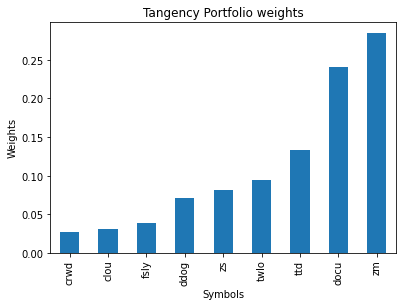

In [ ]:
max_sr = pd.Series(max_sr, index=names)
max_sr = max_sr.sort_values()
print(max_sr)
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Asset')
ax1.set_ylabel("Weights")
ax1.set_title("Tangency Portfolio weights")
max_sr.plot(kind = 'bar')
plt.show();

In [ ]:
print(sharpe_ratio.max())

2.9236960505222642


In [ ]:
print(port_risk.min())

0.39913479631159055


Symbols
fsly    0.011125
ttd     0.026914
ddog    0.032512
twlo    0.074391
crwd    0.086723
docu    0.095130
zm      0.133570
zs      0.168743
clou    0.370892
dtype: float64


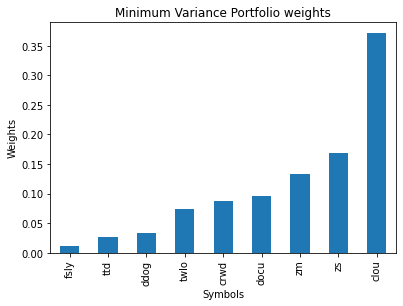

In [ ]:
min_var = pd.Series(min_var, index=names)

min_var = min_var.sort_values()
print(min_var)
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Asset')
ax1.set_ylabel("Weights")
ax1.set_title("Minimum Variance Portfolio weights")
min_var.plot(kind = 'bar')
plt.show();

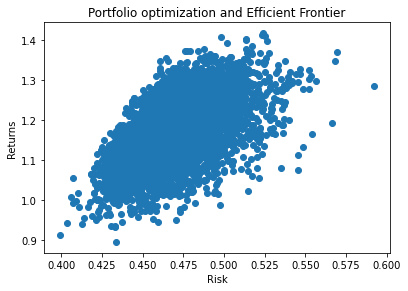

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Risk')
ax1.set_ylabel("Returns")
ax1.set_title("Portfolio optimization and Efficient Frontier")
plt.scatter(port_risk, port_returns)
plt.show();

#Maximum Diversification 

In [ ]:
# 여기서 부터 max var 을 구현할려고 했으나 실패 
#https://thequantmba.wordpress.com/2016/12/14/risk-parityrisk-budgeting-portfolio-in-python/
#위에 있는 코드 자체가 불안정해서 잘이해가 안감. 
from scipy.optimize import minimize
def calc_diversification_ratio(w, V):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    
    # portfolio vol
    #port_vol = np.sqrt(calculate_portfolio_var(w, V))
    port_vol = np.sqrt(np.dot(w, np.dot(V, w.T)))
   #
    diversification_ratio = w_vol/port_vol
    #print(diversification_ratio.shape)
    # return negative for minimization problem (maximize = minimize -)
    
    return -diversification_ratio
def total_weight_constraint(x):
    return np.sum(x)-1.0
def long_only_constraint(x):
    return x
#####################################################################
#               PORTFOLIO Optimization functions                    #
#####################################################################

def max_div_port(w0, V, bnd=None, long_only=True):
    # w0: initial weight
    # V: covariance matrix
    # bnd: individual position limit
    # long only: long only constraint
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only: # add in long only constraint
        cons = cons + ({'type': 'ineq', 'fun':  long_only_constraint},)
    res = minimize(calc_diversification_ratio, w0, bounds=bnd, args=V, method='SLSQP', constraints=cons)
    
    return res

In [ ]:

w0=[1.0/len(min_var)]*len(min_var)
V=cov_mat
max_div=max_div_port(w0,V,bnd=None, long_only=True)
max_div=max_div.x
max_div

array([2.41463612e-02, 1.25972551e-01, 1.50123537e-01, 1.22648205e-01,
       1.67234886e-01, 5.45905146e-02, 2.27099717e-01, 1.28184227e-01,
       2.21719344e-17])

Symbols
clou    2.217193e-17
crwd    2.414636e-02
twlo    5.459051e-02
fsly    1.226482e-01
ddog    1.259726e-01
zs      1.281842e-01
docu    1.501235e-01
ttd     1.672349e-01
zm      2.270997e-01
dtype: float64


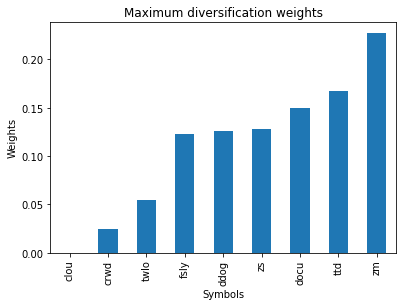

In [ ]:
max_div = pd.Series(max_div, index=names)
max_div = max_div.sort_values()
print(max_div)
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Asset')
ax1.set_ylabel("Weights")
ax1.set_title("Maximum diversification weights")
max_div.plot(kind = 'bar')
plt.show();

#Equal Risk Contribution 

In [ ]:
!pip install future

In [ ]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as pl
from numpy.linalg import inv, pinv
from scipy.optimize import minimize

In [ ]:
 # risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w) #리스트를 행벡터로 만드네요. 처음부터 (1*n)메트릭스로 만드네요.  
    #V는 메트릭스거든요. 
    return (w*V*w.T)[0,0] #포트폴리오의 분산이네요. 메트릭스로 지정을 해야 이런식의 내적이 가능함. 
def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T #n*n   n*1  --> n*1
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma  #n*1  n*1  --> n*1
    return RC #n*1 :  risk contribution 
def risk_budget_objective(x,pars): #x 가변수로서 내가 원하는 optimal x 를 구하는 변수입니다. 
    # calculate portfolio risk
    V = pars[0]# covariance table  n*n
    x_t = pars[1] # risk target in percent of portfolio risk 1*n
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma 1*1
    risk_target = np.asmatrix(np.multiply(sig_p,x_t)) #1*1  1*n  --> 1*n
    asset_RC = calculate_risk_contribution(x,V)  #n*1
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error n*1  n*1
    return J
def total_weight_constraint(x): #이러한 형태에는 익숙치 않네요. 
    return np.sum(x)-1.0
def long_only_constraint(x): #이러한 형태에는 익숙치 않아요. 
    return x
x_t=[1.0/len(min_var)]*len(min_var)
w0=[1.0/len(min_var)]*len(min_var)
#V=cov_mat
V=np.matrix(cov_mat)
cons = ({'type': 'eq', 'fun': total_weight_constraint},
{'type': 'ineq', 'fun': long_only_constraint})
res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, options={'disp': True})
w_rb = res.x
w_rb

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.21520248508629e-07
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 7


array([0.09083494, 0.09902967, 0.13149575, 0.07515888, 0.10054775,
       0.11194183, 0.10909691, 0.11032869, 0.17156558])

Symbols
fsly     7.515888
crwd     9.083494
ddog     9.902967
ttd     10.054775
zm      10.909691
zs      11.032869
twlo    11.194183
docu    13.149575
clou    17.156558
dtype: float64


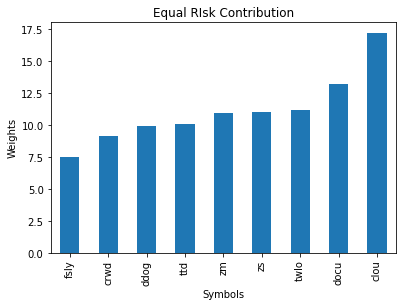

In [ ]:
w_rb = pd.Series(w_rb*100, index=names)
w_rb = w_rb.sort_values()
print(w_rb)
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Asset')
ax1.set_ylabel("Weights")
ax1.set_title("Equal RIsk Contribution")
w_rb.plot(kind = 'bar')
plt.show();